# Deep Learning | Visión Artíficial
---

*Creation Date : 27-May-2023*

- **Notebook** by Julio César Martínez I.
- **Supported** by Senior Data Scientist Fransisco Alfaro & Lead Data Scientist Alfonso Tobar
- **Code Reviewer** by Carlos Ortíz

# Tabla de Contenidos
---

1. Introducción
2. Carga de Datos
3. EDA / Explore Data Analyze
4. Modelado
5. GPU Script
6. Conclusiones

# Apache Licence
---

Copyright @2023 by Julio César Martínez Izaguirre

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License

## Introducción 
---

La tecnología de visión artificial **proporciona** a los equipos industriales la **capacidad** de "ver" lo que están haciendo y **tomar decisiones** rápidas en función de lo que ven. Los usos más comunes de la visión artificial son la **inspección visual** y la **detección de defectos**, la colocación y medición de piezas, además de identificar, clasificar y rastrear productos.

La visión artificial es una de las **tecnologías fundacionales** de la automatización industrial. Ha ayudado a mejorar la calidad de los productos, a acelerar la producción y a optimizar la fabricación y la logística durante décadas. Y ahora, esta tecnología contrastada, se fusiona con la inteligencia artificial para liderar la transición hacia la industria 4.0.

La **IA** expande los algoritmos de la visión por ordenador clásica con modelos llamados redes neuronales. Para mejorar la precisión y la velocidad, los **científicos de datos** crean modelos específicos de red neuronal para aplicaciones concretas. Este proceso, conocido como inferencia del aprendizaje profundo, permite que los ordenadores reconozcan diferencias muy sutiles como el más mínimo desajuste en los patrones de un tejido o fallos microscópicos en placas de circuitos.

Esto último es el caso de nuestro proyecto, donde la empresa **Good Seed** requiere de un modelo específico para detección de edades de las personas. Veremos más sobre esto en la descripción del proyecto.

# Librerías Requeridas
---

1. Pandas
2. NumPy
3. Matplotlib
4. Tensorflow

# Descripción del Proyecto
---

A la cadena de supermercados **Good Seed** le gustaría explorar si la **ciencia de los datos** a través de las técnicas de **Deep Learning** puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de **no vender** alcohol a personas **menores** de edad. Nos piden que hagamos esa evaluación, así que, tendremos en cuenta lo siguiente:

- Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol
- Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto
- La tarea, entonces, es construir y evaluar un modelo para verificar la edad de las personas

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

print('Pandas Version:    ', pd.__version__)
print('Numpy Version:     ', np.__version__)
print('Tensorflow Version:', tf.__version__)

Pandas Version:     1.2.4
Numpy Version:      1.21.1
Tensorflow Version: 2.7.0


## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Recomendamos crear un generador con ImageDataGenerator.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
path = '/datasets/faces/final_files/'

## EDA

**Información General del Set**

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


**Estadísticas Resumidas**

In [5]:
# Observando distribución
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


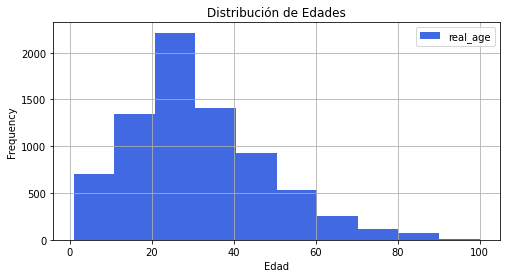

In [6]:
# Visualización de distribución
labels.plot(kind='hist', figsize=(8,4), color='royalblue')
plt.title('Distribución de Edades')
plt.xlabel('Edad')
plt.grid()
plt.show();

**Imprimiendo 10 Fotos del Dataframe**

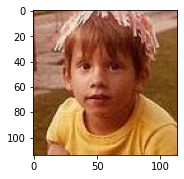

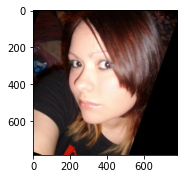

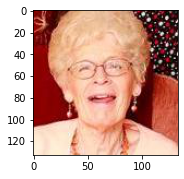

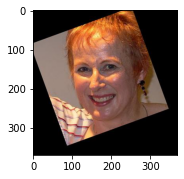

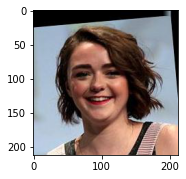

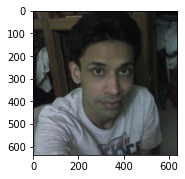

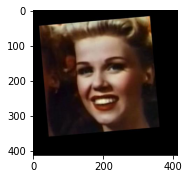

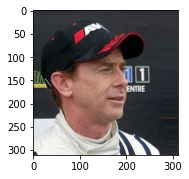

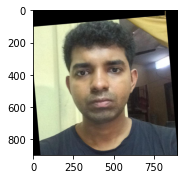

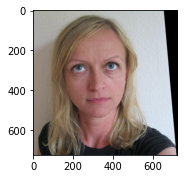

In [7]:
for x in range(10):
    image = Image.open(f'/datasets/faces/final_files/00000{x}.jpg')
    array = np.array(image)
    fig = plt.subplots(figsize=(15,15))
    if x < 5:
        plt.subplot(2, 5, x+1)
        plt.imshow(array)
    else:
        plt.subplot(2, 5, x+1)
        plt.imshow(array)

### Conclusiones

- Encontramos un total de 7,591 fotografías, algunas de ellas no están alineadas correctamente ya que presentan huecos de color negro.
- La edad máxima de nuestro set es de 100 años mientras que la edad mínima es de 1 año.
- La edad promedio del conjunto de datos ronda los 31 años.
- Nuestros datos tienen una distribución normal con un sesgo a la derecha.

## Modelado

Definimos las funciones necesarias para entrenar el modelo en la plataforma GPU de TripleTen y crearemos un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedremos definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script. Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construimos el modelo.

In [9]:
def load_train(path='/datasets/faces/final_files/'):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        fill_mode='nearest')

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

In [10]:
def load_test(path='/datasets/faces/final_files/'):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        fill_mode='nearest')
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224,224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
  
    return test_datagen_flow

In [11]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    backbone=ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
  
    optimizer = Adam(lr=0.0001)
    model.compile(
        loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [12]:
def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=7,
    steps_per_epoch=None,
    validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
  
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    
    return model

## Preparar el Script para Ejecutarlo en la Plataforma GPU

Una vez que hayas definidas las funciones necesarias, vamos a redactar un script para la plataforma GPU de TripleTen, luego vamos a descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización.

In [13]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def load_train(path='/datasets/faces/final_files/'):
 
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.25,
      fill_mode='nearest')

  train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=pd.read_csv('/datasets/faces/labels.csv'),
      directory='/datasets/faces/final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      subset='training',
      seed=12345)
  
  return train_datagen_flow

def load_test(path='/datasets/faces/final_files/'):
    
  test_datagen = ImageDataGenerator(
      validation_split=0.25,
      rescale=1./255,
      fill_mode='nearest')
    
  test_datagen_flow = test_datagen.flow_from_dataframe(
      dataframe=pd.read_csv('/datasets/faces/labels.csv'),
      directory='/datasets/faces/final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224,224),
      batch_size=16,
      class_mode='raw',
      subset='validation',
      seed=12345)
  
  return test_datagen_flow

def create_model(input_shape):

  backbone=ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
 
  model = Sequential()
  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation='relu'))
  
  optimizer = Adam(lr=0.0001)
  model.compile(
      loss='mse', optimizer=optimizer, metrics=['mae'])

  return model

def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=7,
    steps_per_epoch=None,
    validation_steps=None):
    
  #  coloca tu código aquí
  if steps_per_epoch is None:
    steps_per_epoch = len(train_data)
  if validation_steps is None:
    validation_steps = len(test_data) 
  
  model.fit(
      train_data,
      validation_data=test_data,
      epochs=epochs,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      verbose=2)
    
  return model

"""
import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    #for fn_name in [load_train, load_test, create_model, train_model]:
        
    #    src = inspect.getsource(fn_name)
    #    f.write(src)
    #    f.write('\n\n')

### El resultado

**Colocaremos el resultado de la plataforma GPU como una celda Markdown aquí.**

2023-05-27 00:38:25.800030: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6

2023-05-27 00:38:25.801621: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6

Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

2023-05-27 00:38:26.788581: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1

2023-05-27 00:38:26.835776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-05-27 00:38:26.835963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s

2023-05-27 00:38:26.835998: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-05-27 00:38:26.836051: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-05-27 00:38:26.837872: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2023-05-27 00:38:26.838196: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2023-05-27 00:38:26.840279: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2023-05-27 00:38:26.841469: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2023-05-27 00:38:26.841524: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2023-05-27 00:38:26.841597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one 
NUMA node, so returning NUMA node zero

2023-05-27 00:38:26.841834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-05-27 00:38:26.841997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2023-05-27 00:38:26.842311: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA

2023-05-27 00:38:26.849327: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300010000 Hz

2023-05-27 00:38:26.850016: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x45b1f60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:

2023-05-27 00:38:26.850047: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version

2023-05-27 00:38:26.939198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-05-27 00:38:26.939532: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x30947c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

2023-05-27 00:38:26.939551: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0

2023-05-27 00:38:26.939731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-05-27 00:38:26.939891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s

2023-05-27 00:38:26.939924: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-05-27 00:38:26.939935: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-05-27 00:38:26.939958: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2023-05-27 00:38:26.939971: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2023-05-27 00:38:26.939985: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2023-05-27 00:38:26.940000: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2023-05-27 00:38:26.940010: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2023-05-27 00:38:26.940066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-05-27 00:38:26.940235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-05-27 00:38:26.940357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2023-05-27 00:38:26.940390: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-05-27 00:38:27.202653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:

2023-05-27 00:38:27.202702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 

2023-05-27 00:38:27.202712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 

2023-05-27 00:38:27.202918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-05-27 00:38:27.203128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-05-27 00:38:27.203269: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

2023-05-27 00:38:27.203338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
    
 7995392/94765736 [=>............................] - ETA: 0s
 
17793024/94765736 [====>.........................] - ETA: 0s

27516928/94765736 [=======>......................] - ETA: 0s

37265408/94765736 [==========>...................] - ETA: 0s

47120384/94765736 [=============>................] - ETA: 0s

56975360/94765736 [=================>............] - ETA: 0s

66879488/94765736 [====================>.........] - ETA: 0s

76685312/94765736 [=======================>......] - ETA: 0s

86581248/94765736 [==========================>...] - ETA: 0s

94773248/94765736 [==============================] - 0s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

Train for 356 steps, validate for 119 steps

Epoch 1/7

2023-05-27 00:38:38.006562: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-05-27 00:38:38.251258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 46s - loss: 203.2651 - mae: 10.3547 - val_loss: 701.7613 - val_mae: 21.4572

Epoch 2/7
356/356 - 37s - loss: 65.9467 - mae: 6.1770 - val_loss: 131.8959 - val_mae: 8.6972

Epoch 3/7
356/356 - 37s - loss: 37.6964 - mae: 4.7197 - val_loss: 96.2380 - val_mae: 7.3479

Epoch 4/7
356/356 - 37s - loss: 24.9128 - mae: 3.8256 - val_loss: 70.1444 - val_mae: 6.3600

Epoch 5/7
356/356 - 37s - loss: 17.5678 - mae: 3.2607 - val_loss: 69.5958 - val_mae: 6.3473

Epoch 6/7
356/356 - 37s - loss: 14.1168 - mae: 2.8536 - val_loss: 72.4004 - val_mae: 6.5831

Epoch 7/7
356/356 - 37s - loss: 12.0119 - mae: 2.6178 - val_loss: 68.7621 - val_mae: 6.2309

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 68.7621 - mae: 6.2309

**Test MAE: 6.2309**

## Conclusiones

Una vez realizado el entrenamiento vamos a darle respuesta a las siguientes preguntas:

**¿Puede la visión artificial ayudar al cliente en este caso?**

Nuestra métrica de evaluación de error absoluto medio fue de 6.2 por lo que consideramos es una buen modelo de acuerdo a los parámetros establecidos por **Good Seed**. Esto significa, que nuestro modelo puede detectar hasta en 94% la precisión con la que detecta el rostro de un menor de edad para no permitirle la venta de alcohol.

**¿Qué otras tareas prácticas podría resolver el cliente con el modelo? Comparte tus ideas al respecto**.

Algunos otros usos en los que se puede implementar este modelo son:

- Seguridad, detección de delincuentes más buscados.
- Labor Social, busqueda de personas perdidas/desaparecidas.
- Business Analyst, detección de la cantidad de niños, adultos y ancianos; sean hombres o mujeres, que ingresan al supermercado para realizar las estadísticas correspondientes y mejorar la toma de decisiones.

Si bien el modelo fue desarrollado para un objetivo en concreto podemos ajustarlo para realizar tareas adicionales que ayuden a **Good Seed** a mejorar sus servicios.

Como extra, la visión artificial aplicada al proceso de fabricación en otras industrias, también puede mejorar la calidad de los productos y la eficiencia general del sistema, aumentar el rendimiento de su línea de producción, reducir los costes de mano de obra y liberar al personal para que puedan centrarse en trabajos de mayor valor.

# Lista de control

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos 
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [x]  El valor EAM del modelo no es superior a 8 
- [x]  El código de entrenamiento del modelo se copió en el notebook final 
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [x] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo